# Application: Visualization in a Full Domain

[Previous Notebook: Interpolation in 2D/1](./NB 3 LAGRANGE2D.ipynb)

## Introduction

This Notebook extends the use of interpolation over a generalized qudrilateral domain, using the geometric transformation into a canonical perfectly square domain, to the case of an irregular geometry that is now partitioned or discretized into a large number of sub-domains or finite elements. The interpolation ideas discussed in [NB-3](./NB 3 LAGRANGE2D.ipynb) are used here to visualize a function in a domain that has been divided in finite elements. Once the computational domain is meshed, the given function is evaluated at the nodal points of each element. The nodal values, together with the mesh information (coordinates of the nodal points and relevant element data), is then passed into a set of plotting subroutines based in interpolation. We will not take care of the interpolation ourselves but instead will use Python's own libraries.   

The notebook covers then the first approximation to meshes and its representation into elements and nodal arrays. Here we will use a mesh that has been previously created and is available in memory and is given in terms of text files.

## Two-dimensional domain
The figure below shows a square domain discretized into cuadrilateral elements. Note that these elements are analogous to the single quadrilateral domains covered in the [NB3](./NB 3 LAGRANGE2D.ipynb). Here we will conduct interpolation over the full domain using constant shape functions corresponding to the canonical perfectly squared element.


<center><img src="img/mydomain.png" alt="mesh" style="width:600px"></center>

The **mesh** or set of **finite elements** is defined by 2 basic geometric elements namely, the nodal points and the elements.The relavant data for a nodal point is a nodal identifier (usually an integer) and its space coordinates. Similarly an element is defined by and ordered arrangement of 4-nodal points. The order of the nodal points defining an element must be consistent with the pre-defined order of the shape functions in the canonical element. The 4 nodal points associated to a given element are called the element **connectivities**. In summary a mesh is defined by the identifiers and spatial coordinates of all the nodal points and by the connectivities of all the elements coverig the computational domain.

A common way to pass a mesh into a finite element program is through text files. In the current example the mesh is represented by two text files (**nodes.txt** and **elements.txt**) which contain the coordinates of all the nodal points and the list of nodal connectivities conforming each element. The figure shows a typical structure of text files used in finite element codes. The file on the left is a **nodes** file where the first column contains the nodal identifier defined by an integer, while columns 2 and 3 contain the spatial coordinates for each node. The file on the right is an **elements** file. The first column contais an integer with the element identifier; columns 2 and 3 store parameters not relevant in this example and columnss 4 to 7 contain integer numbers defining the nodal connectivities for the specific element. At this point we won't focus in how to create these specific text files but will assume that the files already reside in memory.


<center><img src="img/textfiles.png" alt="files" style="width:600px"></center>


### Problem definition
We want to use computational tools based on two-dimensional interpolation theory to visualize the function:

$$f(x,y) = (x^2 + y^2)^p$$

over a rectangular domain. For that purpose we will:

* Create a mesh or set of nodal points arranged into quadrilateral finite elements.

* Evaluate the function in each nodal point.

* Interpolate the function in each element using the nodal solution.

* Visualize the solution over the full domain.


The resulting Python code will be composed by a main program and a set of subroutines used to perform the interpolation at the element level and to visualize the solution over the complete doamin. As in previous problems the Python code starts by importing libraries. In this initial block of code we also define the function of interest.

In [21]:
%matplotlib inline        
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, CubicTriInterpolator
import numpy as np
import sympy as sym
#
def myfunction(x, y, p):
    """
    Template for user defined elasticity solution.
    """
    ux=(x**2.+y**2.)**p
    return ux

### Interpolation and visualization subroutines
For the visualization per se we will use subroutines extracted from the post-processing modules in the finite element code [SolidsPY](https://github.com/AppliedMechanics-EAFIT/SolidsPy). These subroutines use a Python [Triangulation object](https://matplotlib.org/api/tri_api.html) where each quadrilateral element is divided into triangles. Python then takes each triangle, together with the nodal values of the variables and conducts local interpolation.

The first subrouine (**plot_SFIELD()**) receives as inputs the solution array **UC** storing the value of the function at each nodal point in the mesh; the mesh (defined in terms of the arrays **nodes** and **elements**) and additional plotting paramters. This subroutine calls a second subroutine called **mesh2tri()** whicho divides each square into triangles as described next.

In [22]:
def plot_SFIELD(UC, nodes, elements, Ngra, plt_type="contourf",  levels=12,
               savefigs=False, title="Solution:"  ):
    """Plots a user defined scalar field using a triangulation.

    Parameters
    ----------
    UC : ndarray (float)
      Array with the displacements.
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    """
    tri = mesh2tri(nodes, elements)
    tri_plot(tri, UC , Ngra , title=r'$U_{var}$',
             figtitle=title + "User variable",
             levels=levels, plt_type=plt_type, savefigs=savefigs,
             filename="uservar.pdf")

Subroutine **mesh2tri()** takes as input parameters the arrays **nodes** and **elements** and use them to convert the finite element mesh into Triangulation objects, which is represented here by the list **tri**. The figure below displays a quad element conformed by 4 nodal points, namely $4 , 5, 6, 2$. Subroutine **mesh2tri()** splits the quad element into two triangles with 3 nodal points $6, 2 , 4$ and $4, 5, 6$. Details about triangular grids in matplotlib can be found here [here](https://matplotlib.org/api/tri_api.html).



<center><img src="img/Triangular.png" alt="triangle" style="width:600px"></center>

All the resulting triangles are stored in the list **triangs** which is later passed in to the Pyhton function **Triangulation()** together with the complete list of nodal coordinates.

In [13]:
def mesh2tri(nodes, elements):
    """Generates a matplotlib.tri.Triangulation object from the mesh

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==3:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==2:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    return tri

Once the triangulization has been performed the resulting object, labeled **tri**, is passed to the plotting function (**tri_plot**) together with the solution vector, to perform the final visualization operation.

In [14]:
def tri_plot(tri, field, Ngra ,  title="", figtitle="", levels=12, savefigs=False,
             plt_type="contourf" , filename="solution_plot.pdf"  ):

    plt.figure(Ngra)
    if plt_type=="pcolor":
        disp_plot = plt.tripcolor
    elif plt_type=="contourf":
        disp_plot = plt.tricontourf
    plt.figure(figtitle)
    disp_plot(tri, field, levels, shading="gouraud")
    plt.title(title)
    plt.colorbar(orientation='vertical')
    plt.axis("image")
    plt.grid()

### Main program: mesh reading and function evaluation

We now read the mesh which is stored in the text files **nodes.txt** and **eles.txt**. The numpy function **loadtxt** reads the text files and make them into arrays **nodes** and **elements** respectively.

In [15]:
nodes        = np.loadtxt('nodes.txt')
elements     = np.loadtxt('eles.txt')
nn =len(nodes[:,0])

The code follows with the extraction of the nodal coordinates from the primary **nodes** array and the initialization of the solution array **SOL[]**.

In [16]:
coords=np.zeros([nn,2])
coords[:,0]=nodes[:,1]
coords[:,1]=nodes[:,2]
SOL = np.zeros([nn])

Now evaluate the solution at each point of coordinates $(x , y)$ and store the result in **SOL[]**.

In [17]:
par1 = 1.0
for i in range(0,nn):
    x = coords[i,0]
    y = coords[i,1]
    uu =myfunction(x,y,par1)
    SOL[i] = uu

In the final step **SOL[]** is passed to **plot_SFIELD()** to conduct the final visualization operation as discussed above.

<Figure size 432x288 with 0 Axes>

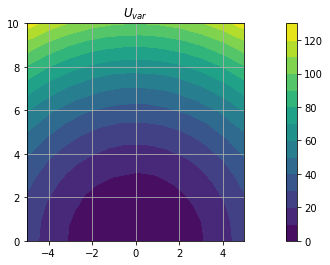

In [18]:
plot_SFIELD(SOL , nodes , elements, 0 , plt_type ="contourf", levels = 12 )

### Class activity
Consider the theory of elasticity solution for a cantilever beam of height $h = 2c$, length $2\ell$ and moment of inertia $I$, submitted to a uniformly distributed load of intensity $q$ [Timoshenko, Stepan P., and J. Goodier. "Theory of elasticity." (2011): 567-567.]:

$$\sigma_{xx}=-\frac q{2I}\left(x^2y-\frac23y^3\right)$$

$$\sigma_{yy}=-\frac q{2I}\left(\frac13y^3-c^2y+\frac23c^3\right)$$

$$\tau_{xy}=-\frac q{2I}\left(c^2-y^2\right)$$



<center><img src="img/beam.png" alt="beam" style="width:600px"></center>


* Identify the problem domain  and use the free three-dimensional mesh generator [Gmsh](http://gmsh.info/) to create a finite element mesh of this domain.

* Use the Python module [meshio](https://github.com/nschloe/meshio) to read the mesh from the **.msh** created file and convert it into the appropriate text files for nodes and elements.

* Use the interpolation and visualization subroutines discussed in the notebook to create an independent script (or notebook) and visualize the principal stresses over the computational domain.

The attached video (in spanish) shows simple steps in the creation and reading of a model combining  [Gmsh](http://gmsh.info/) and [meshio](https://github.com/nschloe/meshio).

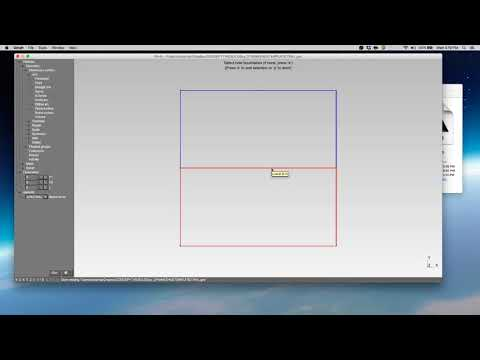

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo('ibeIKaSYG2U')

In [20]:
# This bit of code is a class added to make the title nice  (thanks to @lorenABarba )
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()